<a href="https://colab.research.google.com/github/SandroMuradashvili/MTL_student_performance/blob/main/MTL_student_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
import torch


In [57]:
# -----------------------------
# 1. Load the data | STEP 1
# -----------------------------
url = "https://raw.githubusercontent.com/SandroMuradashvili/MTL_student_performance/refs/heads/main/data/student-por.csv"

# Read CSV with correct separator
#df = pd.read_csv(url, sep=';')
df = pd.read_csv(url, sep=';', header=0)  # explicitly use first row as header


# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()


# Check columns
print(df.columns.tolist())

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [58]:
#TEST
# Show first 5 rows to understand the data
print("First 5 rows of raw dataset:")
print(df.head())
# Check columns
print(df.columns.tolist())

First 5 rows of raw dataset:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', '

In [59]:
# -----------------------------
# 2. Separate features and targets
# -----------------------------
# X = all columns except targets
# y_grade = final grade (G3)
# y_romantic = binary (0/1) for romantic relationship
X = df.drop(columns=['G3', 'romantic'])
y_grade = df['G3']
y_romantic = df['romantic'].map({'yes': 1, 'no': 0})  # convert to 0/1


In [60]:
# -----------------------------
# 3. Split data into train, val, test
# -----------------------------
# First split: train+val vs test (12% test)
X_temp, X_test, y_grade_temp, y_grade_test, y_romantic_temp, y_romantic_test = train_test_split(
    X, y_grade, y_romantic, test_size=0.12, random_state=42, shuffle=True
)

# Second split: train vs val (15% of train+val becomes validation)
X_train, X_val, y_grade_train, y_grade_val, y_romantic_train, y_romantic_val = train_test_split(
    X_temp, y_grade_temp, y_romantic_temp, test_size=0.15, random_state=42, shuffle=True
)

#ADJUST 1 | 0.12 & 0.15


In [61]:
#Test
# Print dataset sizes
print("\nDataset sizes after splitting:")
print(f"Train: {X_train.shape[0]} samples (~75%)")
print(f"Validation: {X_val.shape[0]} samples (~13%)")
print(f"Test: {X_test.shape[0]} samples (~12%)")


Dataset sizes after splitting:
Train: 485 samples (~75%)
Validation: 86 samples (~13%)
Test: 78 samples (~12%)


In [62]:
# -----------------------------
# 4. Identify categorical and numerical columns
# -----------------------------
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [63]:
#Test
print("\nCategorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet']
Numerical columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


In [64]:
# -----------------------------
# 5. Preprocessing: One-hot encode categorical, standardize numerical
# -----------------------------
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)  # avoid dummy variable trap
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Fit the preprocessor only on training data to avoid data leakage
preprocessor.fit(X_train)

# Transform train, val, test sets
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

In [65]:
#Test
# Debug prints: check shapes after preprocessing
# print("\nPreprocessing done. Shapes of processed datasets:")
# print("X_train_proc:", X_train_proc.shape)
# print("X_val_proc:", X_val_proc.shape)
# print("X_test_proc:", X_test_proc.shape)

print("X_train_proc:", X_train_proc)


X_train_proc: [[ 0.16583729  1.34192829  1.58561977 ...  0.          1.
   1.        ]
 [ 0.97827249 -1.32179021 -1.17074434 ...  1.          0.
   1.        ]
 [-0.64659791  1.34192829  1.58561977 ...  1.          0.
   1.        ]
 ...
 [-0.64659791 -0.43388404 -0.25195631 ...  1.          1.
   1.        ]
 [ 0.16583729  0.45402212 -0.25195631 ...  1.          1.
   0.        ]
 [ 0.97827249  0.45402212  0.66683173 ...  1.          1.
   1.        ]]


In [66]:

# -----------------------------
# 6. Create PyTorch Dataset class
# -----------------------------
class StudentDataset(Dataset):
    def __init__(self, X, y_grade, y_romantic):
        # Convert numpy arrays / pandas Series to PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_grade = torch.tensor(y_grade.values, dtype=torch.float32).unsqueeze(1)  # regression target
        self.y_romantic = torch.tensor(y_romantic.values, dtype=torch.long)  # classification target

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_grade[idx], self.y_romantic[idx]

# -----------------------------
# 7. Create datasets and loaders
# -----------------------------
train_dataset = StudentDataset(X_train_proc, y_grade_train, y_romantic_train)
val_dataset = StudentDataset(X_val_proc, y_grade_val, y_romantic_val)
test_dataset = StudentDataset(X_test_proc, y_grade_test, y_romantic_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

#ADJUST 2 | batch size=32
# Batch smaller | Often needs smaller LR |
# Batch larger | Can use bigger LR |

print("\nPyTorch DataLoaders ready!")
print("Example batch from train_loader:")
example_batch = next(iter(train_loader))
print("X batch shape:", example_batch[0].shape)
print("y_grade batch shape:", example_batch[1].shape)
print("y_romantic batch shape:", example_batch[2].shape)

print()

#STEP 1 FINISHED


PyTorch DataLoaders ready!
Example batch from train_loader:
X batch shape: torch.Size([32, 40])
y_grade batch shape: torch.Size([32, 1])
y_romantic batch shape: torch.Size([32])



In [67]:
encoded = pd.get_dummies(df, drop_first=False)
print(encoded.columns)
print("Total features:", len(encoded.columns))


Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R',
       'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T',
       'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other',
       'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home',
       'reason_other', 'reason_reputation', 'guardian_father',
       'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes',
       'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no',
       'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no',
       'higher_yes', 'internet_no', 'internet_yes', 'romantic_no',
       'romantic_yes'],
      dtype='object')
Total features: 59


In [68]:
# 1) All columns after one-hot encoding (or just the DataFrame you used for preprocessing)
print("All columns in encoded DataFrame:")
print(encoded.columns.tolist())

# 2) Columns used for training (X)
print("\nColumns used in X (inputs to the model):")
print(X.columns.tolist())

# 3) Number of features in input to the model
print("\nNumber of input features:", X_train_proc.shape[1])

encoded = pd.get_dummies(df, drop_first=False)
print(encoded.columns)
print("Total features:", len(encoded.columns))



All columns in encoded DataFrame:
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'school_GP', 'school_MS', 'sex_F', 'sex_M', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'schoolsup_no', 'schoolsup_yes', 'famsup_no', 'famsup_yes', 'paid_no', 'paid_yes', 'activities_no', 'activities_yes', 'nursery_no', 'nursery_yes', 'higher_no', 'higher_yes', 'internet_no', 'internet_yes', 'romantic_no', 'romantic_yes']

Columns used in X (inputs to the model):
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'stud

In [69]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_dim=40, shared_dim1=128, shared_dim2=64, head_dim=32, dropout=0.3):
        super(MultiTaskModel, self).__init__()

        # -------------------------
        # 1) Shared Body (feature extractor) | STEP 2
        # -------------------------
        self.shared_body = nn.Sequential(
            nn.Linear(input_dim, shared_dim1),   # 40 -> 128
            nn.BatchNorm1d(shared_dim1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(shared_dim1, shared_dim2), # 128 -> 64
            nn.BatchNorm1d(shared_dim2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # -------------------------
        # 2) Head 1 → Grade Regression (predict G3)
        # -------------------------
        self.head_grade = nn.Sequential(
            nn.Linear(shared_dim2, head_dim),    # 64 -> 32
            nn.ReLU(),
            nn.Linear(head_dim, 1)               # Output single number
        )

        # -------------------------
        # 3) Head 2 → Romantic Classification (0/1)
        # -------------------------
        self.head_romantic = nn.Sequential(
            nn.Linear(shared_dim2, head_dim),    # 64 -> 32
            nn.ReLU(),
            nn.Linear(head_dim, 2)               # 2 output logits
        )

    def forward(self, x):
        shared = self.shared_body(x)         # common features
        grade_pred = self.head_grade(shared) # regression output
        romantic_logits = self.head_romantic(shared) # classification logits
        return grade_pred, romantic_logits


In [70]:

# Define Model

model = MultiTaskModel(input_dim=40)

# -------------------------------
# 1) Loss functions | STEP 3
# -------------------------------
loss_regression = nn.MSELoss()         # for grade prediction (G3)
loss_classification = nn.CrossEntropyLoss()  # for romantic yes/no

# -------------------------------
# 2) Optimizer
# -------------------------------
optimizer = Adam(model.parameters(), lr=0.001)

# TO PLOT LATER
train_total_losses, train_grade_losses, train_rom_losses = [], [], []
val_grade_losses, val_rom_losses = [], []

import matplotlib.pyplot as plt

def plot_losses(train_total, train_grade, train_rom, val_grade, val_rom):
    epochs = range(1, len(train_total)+1)

    plt.figure(figsize=(12,5))

    # Total loss
    plt.subplot(1,3,1)
    plt.plot(epochs, train_total, label='Train Total')
    plt.title("Train Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Grade loss
    plt.subplot(1,3,2)
    plt.plot(epochs, train_grade, label='Train Grade')
    plt.plot(epochs, val_grade, label='Val Grade')
    plt.title("Grade Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Romantic loss
    plt.subplot(1,3,3)
    plt.plot(epochs, train_rom, label='Train Romantic')
    plt.plot(epochs, val_rom, label='Val Romantic')
    plt.title("Romantic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


# -------------------------------
# 3) Training Loop
# -------------------------------
def train_model(model, train_loader, val_loader, alpha=0.5, epochs=30, device="cpu"):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_grade_loss = 0
        total_rom_loss = 0

        for X, y_grade, y_romantic in train_loader:

            X, y_grade = X.to(device), y_grade.to(device).float()
            y_romantic = y_romantic.to(device).long()

            # Forward pass → two outputs
            pred_grade, romantic_logits = model(X)

            # --- Compute losses separately ---
            grade_loss = loss_regression(pred_grade, y_grade)
            romantic_loss = loss_classification(romantic_logits, y_romantic)

            # --- Combine losses ---
            #total_loss = grade_loss + romantic_loss # original.

            # -----------------------------
            # Weighted loss # BONUS
            # -----------------------------
            # alpha = 0.005   # <--- importance of G3 in % | UPDATE, instead of manual alpha is passed as parameter
            total_loss = alpha * grade_loss + (1 - alpha) * romantic_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # accumulate stats for reporting later
            total_train_loss += total_loss.item()
            total_grade_loss += grade_loss.item()
            total_rom_loss   += romantic_loss.item()


        # -----------------------------
        # Validation (no backprop)
        # -----------------------------
        model.eval()
        val_grade_loss = 0
        val_rom_loss = 0

        with torch.no_grad():
            for X, y_grade, y_romantic in val_loader:
                X, y_grade = X.to(device), y_grade.to(device).float()
                y_romantic = y_romantic.to(device).long()

                pred_g, logit_r = model(X)

                val_grade_loss += loss_regression(pred_g, y_grade).item()
                val_rom_loss   += loss_classification(logit_r, y_romantic).item()


        # store epoch losses
        train_total_losses.append(total_train_loss)
        train_grade_losses.append(total_grade_loss)
        train_rom_losses.append(total_rom_loss)
        val_grade_losses.append(val_grade_loss)
        val_rom_losses.append(val_rom_loss)

        # Print each epoch for debugging purposes
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train total: {total_train_loss:.4f} | "
              f"Grade: {total_grade_loss:.4f} | "
              f"Romantic: {total_rom_loss:.4f} || "
              f"Val Grade: {val_grade_loss:.4f} | Val Romantic: {val_rom_loss:.4f}")



In [71]:
# -------------------------------
#  STEP 4
# -------------------------------

def evaluate_on_test(model, test_loader, device="cpu"):
    model.eval()

    true_grade = []
    pred_grade = []

    true_rom = []
    pred_rom = []

    with torch.no_grad():
        for X, y_grade, y_romantic in test_loader:
            X = X.to(device)

            # forward pass
            grade_out, romantic_logits = model(X)

            # ---- Regression ----
            true_grade.extend(y_grade.numpy())
            pred_grade.extend(grade_out.cpu().numpy())

            # ---- Classification ----
            predicted = torch.argmax(romantic_logits, dim=1).cpu()

            true_rom.extend(y_romantic.numpy())
            pred_rom.extend(predicted.numpy())

    # ---- Compute Metrics ----
    mae = mean_absolute_error(true_grade, pred_grade)
    accuracy = accuracy_score(true_rom, pred_rom)
    f1 = f1_score(true_rom, pred_rom, pos_label=1)   # only for "yes" class

    print("\n========== FINAL TEST RESULTS ==========")
    print(f"Mean Absolute Error (G3 Regression): {mae:.4f}")
    print(f"Accuracy (Romantic Status)        : {accuracy:.4f}")
    print(f"F1-Score (Romantic = YES)         : {f1:.4f}")
    print("=========================================")

    return mae, accuracy, f1




Epoch 1/30 | Train total: 34.0220 | Grade: 2303.5887 | Romantic: 11.0971 || Val Grade: 442.3652 | Val Romantic: 2.0378
Epoch 2/30 | Train total: 29.9610 | Grade: 1966.5157 | Romantic: 10.3999 || Val Grade: 381.1527 | Val Romantic: 1.8991
Epoch 3/30 | Train total: 26.0200 | Grade: 1552.5016 | Romantic: 10.6010 || Val Grade: 283.5200 | Val Romantic: 1.8597
Epoch 4/30 | Train total: 20.3767 | Grade: 1039.2638 | Romantic: 10.0849 || Val Grade: 183.4267 | Val Romantic: 1.8699
Epoch 5/30 | Train total: 15.4252 | Grade: 535.0644 | Romantic: 10.1763 || Val Grade: 112.8031 | Val Romantic: 1.8627
Epoch 6/30 | Train total: 12.4291 | Grade: 258.1142 | Romantic: 9.9474 || Val Grade: 55.5996 | Val Romantic: 1.8369
Epoch 7/30 | Train total: 11.0778 | Grade: 144.9453 | Romantic: 9.7256 || Val Grade: 38.5193 | Val Romantic: 1.8171
Epoch 8/30 | Train total: 10.8883 | Grade: 118.3635 | Romantic: 9.8027 || Val Grade: 29.0676 | Val Romantic: 1.8016
Epoch 9/30 | Train total: 10.3214 | Grade: 110.2783 | Roma

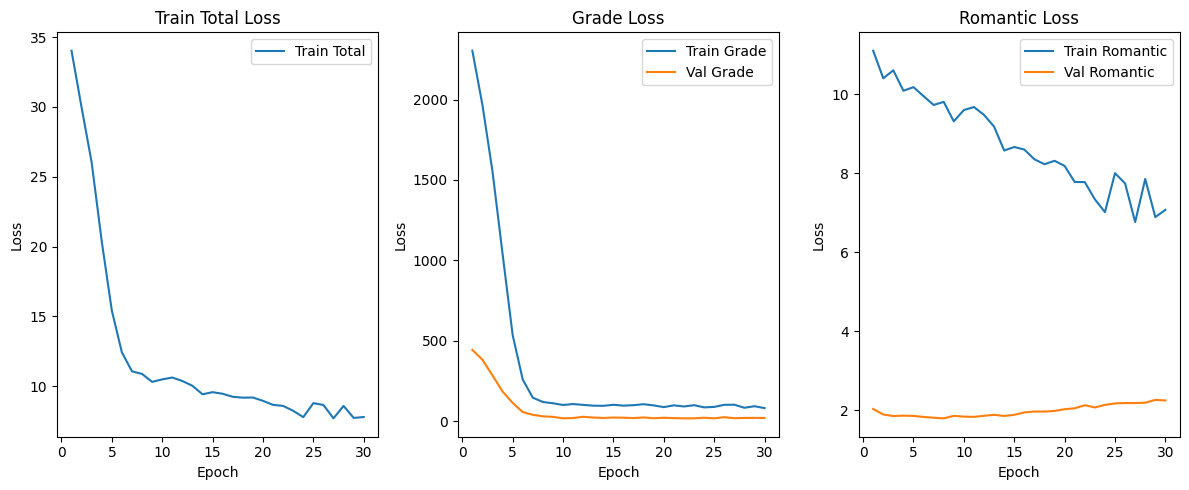

In [72]:
train_model(model, train_loader, val_loader,alpha=0.01, epochs=30)

evaluate_on_test(model, test_loader)

# after training finishes
plot_losses(train_total_losses, train_grade_losses, train_rom_losses,
            val_grade_losses, val_rom_losses)

torch.save(model.state_dict(), "best_model.pth")



In [73]:
model_2 = MultiTaskModel(input_dim=40)

optimizer = Adam(model_2.parameters(), lr=0.001)

train_model(model_2, train_loader, val_loader,alpha=0.5, epochs=30)

evaluate_on_test(model_2, test_loader)

torch.save(model_2.state_dict(), "best_model_2.pth")

# ALPHA



Epoch 1/30 | Train total: 1092.0311 | Grade: 2172.8727 | Romantic: 11.1894 || Val Grade: 416.6969 | Val Romantic: 1.9841
Epoch 2/30 | Train total: 920.4470 | Grade: 1830.1706 | Romantic: 10.7235 || Val Grade: 331.1371 | Val Romantic: 1.8747
Epoch 3/30 | Train total: 675.6934 | Grade: 1340.7816 | Romantic: 10.6051 || Val Grade: 220.5551 | Val Romantic: 1.8488
Epoch 4/30 | Train total: 416.1061 | Grade: 821.6183 | Romantic: 10.5939 || Val Grade: 153.5457 | Val Romantic: 1.8885
Epoch 5/30 | Train total: 201.9442 | Grade: 393.0929 | Romantic: 10.7955 || Val Grade: 93.2740 | Val Romantic: 1.8388
Epoch 6/30 | Train total: 85.6627 | Grade: 160.8410 | Romantic: 10.4843 || Val Grade: 56.5358 | Val Romantic: 1.8917
Epoch 7/30 | Train total: 57.9056 | Grade: 104.9696 | Romantic: 10.8416 || Val Grade: 25.3805 | Val Romantic: 1.8291
Epoch 8/30 | Train total: 46.6745 | Grade: 82.6215 | Romantic: 10.7275 || Val Grade: 17.7720 | Val Romantic: 1.8339
Epoch 9/30 | Train total: 47.7883 | Grade: 85.1502 |

In [74]:
model_3 = MultiTaskModel(input_dim=40)

optimizer = Adam(model_3.parameters(), lr=0.001)

train_model(model_3, train_loader, val_loader,alpha=0.8, epochs=30)

evaluate_on_test(model_3, test_loader)

torch.save(model_3.state_dict(), "best_model_3.pth")

Epoch 1/30 | Train total: 1781.3523 | Grade: 2223.9863 | Romantic: 10.8166 || Val Grade: 432.2537 | Val Romantic: 1.9186
Epoch 2/30 | Train total: 1529.4341 | Grade: 1909.1245 | Romantic: 10.6722 || Val Grade: 352.3884 | Val Romantic: 1.8861
Epoch 3/30 | Train total: 1090.5900 | Grade: 1360.6072 | Romantic: 10.5211 || Val Grade: 239.6024 | Val Romantic: 1.8730
Epoch 4/30 | Train total: 642.8040 | Grade: 800.8476 | Romantic: 10.6295 || Val Grade: 138.3629 | Val Romantic: 1.8403
Epoch 5/30 | Train total: 296.4617 | Grade: 367.8995 | Romantic: 10.7103 || Val Grade: 84.0877 | Val Romantic: 1.8539
Epoch 6/30 | Train total: 120.4674 | Grade: 147.9273 | Romantic: 10.6280 || Val Grade: 42.6672 | Val Romantic: 1.8888
Epoch 7/30 | Train total: 87.5063 | Grade: 106.7641 | Romantic: 10.4752 || Val Grade: 24.8735 | Val Romantic: 1.8527
Epoch 8/30 | Train total: 83.2690 | Grade: 101.4574 | Romantic: 10.5155 || Val Grade: 20.3804 | Val Romantic: 1.8071
Epoch 9/30 | Train total: 91.8770 | Grade: 112.2